# WRC Overall

Generate a graphic enriched tabel summarising rally evolution over multiple stages, rebased to a specific driver.

In [163]:
if __name__=='__main__':
    %load_ext autoreload
    %autoreload 2
    
    import notebookimport
    
    sr = __import__("Charts - Stage Results")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
# TO DO
# do a step line chart for relative / rebased positions ahead / behind

In [165]:
import pandas as pd

from IPython.display import HTML

import dakar_utils as dakar
from dakar_utils import moveColumn, sparkline2, sparklineStep, moreStyleDriverSplitReportBaseDataframe


In [178]:
dbname2='mexico19.db'
conn2 = sqlite3.connect(dbname2)

c2 = conn2.cursor()


In [167]:
from IPython.display import HTML

In [168]:
def _rebaseTimes(times, bib=None):
    if bib is None: return times
    return times - times.loc[bib]

In [169]:
REBASER=306

In [170]:
q= 'SELECT entryId, `driver.code` AS Code FROM startlists'
codes = pd.read_sql(q,conn2).set_index('entryId')
codes.head()

,Code
entryId,
19180,OGI
19181,SUN
19182,LAP
19183,MEE
19184,SOR


In [180]:
#For WRC
YEAR=2019
rc='RC1'
rally='Mexico'
typ='overall'
wREBASE='OGI'

### Day Based Reporting

How do we limit the report to just show the stages on a particular day, or particular loop?

In [181]:
#Based on a function in Itinerary Basics
def dbGetSSitinerary(conn, rally, year=YEAR):
    ''' Get dataframe containing time control details for a specified rally. '''
    q='''
    SELECT il.name AS date, itc.*, ce.timeZoneOffset,
         isc.itinerarySectionId, isc.name AS section, isc.`order`
    FROM itinerary_controls itc
    JOIN championship_events ce ON itc.eventId=ce.eventId
    JOIN itinerary_sections isc ON itc.`itinerarySections.itinerarySectionId`=isc.itinerarySectionId
    JOIN itinerary_legs il ON isc.itineraryLegId=il.itineraryLegId
    WHERE ce.`country.name`="{rally}" AND strftime('%Y', startDate)='{year}'
            AND firstCarDueDateTimeLocal NOT NULL 
            AND itc.type='StageStart'
            ORDER BY firstCarDueDateTimeLocal 
    '''.format(rally=rally, year=year)
    time_controls = pd.read_sql(q,conn)
    time_controls['firstCarDueDateTimeLocal']=pd.to_datetime(time_controls['firstCarDueDateTimeLocal'])
    return time_controls

Create a day index so that we can limit reports to show a particular day, set of days, or up to and including a particular day.

We could also support reporting by a section selection.

In [173]:
def listify(items):
    ''' Turn an argument to a list. '''
    return [] if items is None else items if isinstance(items, list) else [items]


def getStagesByDay(daynums=None, sections=None):
    ''' Return the stages for a given day, days, section or sections. '''
    daynums = listify(daynums)
    sections = listify(sections)
    
    schedule = dbGetSSitinerary(conn2,rally)
    #The grouper will return a group ID, but not in order?
    #schedule['daynum'] = schedule.groupby('date').grouper.label_info
    #https://stackoverflow.com/a/41638343/454773
    schedule['index'] = schedule[['date']].merge( schedule.drop_duplicates( 'date' ).reset_index(), on='date' )['index'].rank(method='dense').astype(int)
    tmp = schedule[['date','code','section','order','index']]
    if daynums:
        tmp = tmp[tmp['index'].isin(daynums)]
    if sections:
        tmp = tmp[tmp['order'].isin(sections)]
    
    return tmp


,date,code,section,order,index
1,Friday 8th March,SS2,Section 2,2,2
2,Friday 8th March,SS3,Section 2,2,2
3,Friday 8th March,SS4,Section 2,2,2


In [182]:

getStagesByDay(sections=2)

,date,code,section,order,index
1,Friday 8th March,SS2,Section 2,2,2
2,Friday 8th March,SS3,Section 2,2,2
3,Friday 8th March,SS4,Section 2,2,2


In [174]:
def gapToLeaderBar(conn, rally, rc, typ, stages=None):
    Xtmpq = sr.dbGetStageRank(conn, rally, rc, typ, stages)#.head()
    Xtmpq = Xtmpq[['entryId','snum', 'diffFirstMs']].pivot(index='entryId',columns='snum',values='diffFirstMs')
    Xtmpq = Xtmpq/1000
    if typ=='stage':
        Xtmpq.columns = ['SS_{}'.format(c) for c in Xtmpq.columns]
    else:
        Xtmpq.columns = ['SS_{}_{}'.format(c, typ) for c in Xtmpq.columns]
    k = '{}GapToLeader'.format(typ)
    Xtmpq[k] = Xtmpq[[c for c in Xtmpq.columns ]].values.tolist()
    Xtmpq[k] = Xtmpq[k].apply(lambda x: [-y for y in x])
    Xtmpq[k] = Xtmpq[k].apply(sparkline2, typ='bar', dot=True)
    return Xtmpq 

def gapBar(df):
    ''' Bar chart showing rebased gap at each stage. '''
    col='Gap'
    df[col] = df[[c for c in df.columns if c.startswith('SS_') and c.endswith('_overall')]].values.tolist()
    df[col] = df[col].apply(lambda x: [-y for y in x])
    df[col] = df[col].apply(sparkline2, typ='bar', dot=False)
    return df

In [186]:
def positionStep(conn, rally, rc, typ, stages=None):
    Xtmpq = sr.dbGetStageRank(conn, rally, rc, typ, stages)#.head()
    Xtmpq = Xtmpq[['entryId','snum', 'position']].pivot(index='entryId',columns='snum',values='position')
    Xtmpq.columns = ['SS_{}_{}_pos'.format(c, typ) for c in Xtmpq.columns]
    k = '{}Position'.format(typ)
    Xtmpq[k] = Xtmpq[[c for c in Xtmpq.columns ]].values.tolist()
    Xtmpq[k] = Xtmpq[k].apply(lambda x: [-y for y in x])
    Xtmpq[k] = Xtmpq[k].apply(sparklineStep)
    return Xtmpq 

# TO DO - this is really clunky; need a better way
def overallAtLastStage(conn, rally, rc, typ, stages=None):
    ''' Get overall rank associated with last stage in table. '''
    Xtmpq = sr.dbGetStageRank(conn, rally, rc, typ, stages)#.head()
    Xtmpq = Xtmpq[['entryId','snum', 'position']].pivot(index='entryId',columns='snum',values='position')
    last = Xtmpq.columns
    return Xtmpq[[last[-1]]]
    

def generateOverallResultsChartable(conn, rally, rc, rebase=None, stages=None, days=None, sections=None):
    ''' Generate overall results table for a particular event. '''
    
    if days:
        stages = listify(stages) + getStagesByDay(daynums=days)['code'].tolist()
    
    if sections:
        stages = listify(stages) + getStagesByDay(sections=sections)['code'].tolist()
        
    wrc = pd.merge(codes, positionStep(conn, rally, rc, 'overall', stages=stages)[['overallPosition']], left_index=True, right_index=True)
    
    wrc = pd.merge(wrc, gapToLeaderBar(conn, rally, rc, 'overall', stages), left_index=True, right_index=True)
    moveColumn(wrc, 'overallGapToLeader', right_of='overallPosition')
    
    
    wrc['Pos'] = overallAtLastStage(conn, rally, rc, typ, stages)
    moveColumn(wrc, 'Pos', right_of='overallGapToLeader')
    
    wrc = pd.merge(wrc, positionStep(conn, rally, rc, 'stage', stages)[['stagePosition']], left_index=True, right_index=True)
    
    wrc = pd.merge(wrc, gapToLeaderBar(conn, rally, rc, 'stage', stages), left_index=True, right_index=True)
    wrc.rename(columns={'stageGapToLeader':'stageWinnerGap'},inplace=True)
    moveColumn(wrc, 'stageWinnerGap', right_of='stagePosition')


    wrc = wrc.sort_values('Pos', ascending=True)
    wrc=wrc.set_index('Code', drop=True)
    #Some tidying up if we have stages in the db but no results...
    wrc=wrc.dropna(how='all', axis='columns')
    
    cols = [c for c in wrc.columns if c.startswith('SS')]
      
    if rebase is not None:
        wrc[cols] = -wrc[cols].apply(_rebaseTimes, bib=rebase, axis=0)
    
    #This needs to be done after rebasing
    wrc = gapBar(wrc)
    moveColumn(wrc, 'Gap', left_of='stagePosition')
    
    return wrc

   

In [187]:
tmp = generateOverallResultsChartable(conn2, rally, rc, rebase=wREBASE, days=1, sections=3)
tmp                
 

,overallPosition,overallGapToLeader,Pos,SS_1_overall,Gap,stagePosition,stageWinnerGap,SS_1
Code,,,,,,,,
LAP,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",1,0.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",0.6
MIK,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",2,0.5,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",0.5
MEE,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",3,-0.0,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-0.0
EVA,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",4,-0.0,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-0.0
NEU,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",5,-0.0,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-0.0
TÄN,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",6,-0.0,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-0.0
OGI,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",7,-0.0,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-0.0
SUN,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",8,-0.9,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-0.9
SOR,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",9,-0.9,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-0.9


In [188]:
wREBASE='OGI'
tmp = generateOverallResultsChartable(conn2, rally, rc, rebase=wREBASE)


In [189]:
s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')

#Introduce a dot marker to highlight winner
display(HTML(s2))
dakar.getTablePNG(s2, fnstub='overall_{}_'.format(wREBASE),scale_factor=2)


,overallPosition,overallGapToLeader,Pos,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,Gap,stagePosition,stageWinnerGap,SS_1,SS_2,SS_3,SS_4
Code,,,,,,,,,,,,,,
MIK,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAdRJREFUeJzt27uKE2EYh/FnxWYbG1kCXsAqeh92ll6Pd2DrHVjZeAe2YmOt8OaERchhzudMxmLZwCCsmHdiovv/dW/z8ZF5%2BGYIMxdd13WIHOjBqTcg/zYFJC4KSFwennoDd3n/ecbHrz9OvY3/zvMnj3jz6sUgaw0W0GKxGGqpvQ9fxnxbFlxfXQ6%2B9n2W5/kv12s0Gh201tFOoLefZnxf5q41buN59/rZQLuSoZ31M9D11SUvnz4%2B9TbkDhdD/Q90jFuY/D2H3sLO%2BgSS8zfYCST3k04gcVFA4qKAxEUBiYsCEhcFJC4KSFwUkLgoIHFRQOKigMRFAYmLAhIXBSQuCkhcFJC4KCBxUUDictSAzIwgCADoug4zIwxDAHa7HWZGFEUAtG3bm7fbLWZGHMcANE2DmZEkCQB1XWNmpGnam7MsA6CqKsyMPL/5tKgsy95cFAVmRlEUwM23UmZGWZa9uaoqALIsw8yo6xqANE17c5IkmBlN0wAQxzFmxna7BSCKIsyMtm178263AyAMQ8yM2zeMgyDAzPa/5WazYTwe7%2Bf1es1kMtnPq9WK6XTam2ez2X5eLpfM5/PfX7Q/pBNIXPRSvbjoBBIXBSQuCkhcFJC4/ARXP/ZNJk4soAAAAABJRU5ErkJggg%3D%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAQ5JREFUeJzt2yEKAkEYhuFvXPEWgtEiZoOo7D3sRotgtlvt3kOwWQUvIBg8giDoGmxiWPdzUNf3ycv8w/CyTJmQZVkmoKDKpzeA30ZAsBAQLNWoq4eQ67PjZKJTs5lvzV6v0FYWu4Xm27muuioJicbtsUatUaG1vnnWbDDTtDuNMuuZEPUSnTOglxTc7uawUbpMdb6cVUtqWg1X6tQ7b95cuWc98zcBSffDXu/X6jf60Q%2B5rLMe/VVAeD8u0bAQECwEBAsBwUJAsBAQLAQECwHBQkCwEBAsBAQLAcFCQLAQECwEBAsBwUJAsBAQLAQECwHBQkCwEBAscV%2Bm8gSn9PgDwUJAsBAQLAQECwHBcgNmyWE3OW2OmwAAAABJRU5ErkJggg%3D%3D"" />",1,0.5,2.9,0.7,1.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAOBJREFUeJzt2bENwjAURdEE0TACG7AFW2WIbMUWbMAIlKZGAsnJw0Csc0oUxS6ufiwzllLKACvtfr0Btk1ARAREZN/07eNY9dhtmob76VT3zvP59e%2BXS%2BWmFni1Vot1PrDW4XodjvNc9/AHj71j00N0ZUCLvNvut9Zqsc4/rLWSTxgRAREREJG2h2h3lN0zgYi0nUA9MlWfmEBEBEREQEQERERARAREREBE3AP9sw3cOZlARAREREBEBEREQEQERERARAREREBEBESkn78yNnDt3yMTiIiAiAiIiICICIjIA5iVJkG6jCupAAAAAElFTkSuQmCC"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAjBJREFUeJzt272KE2EUxvH/iotsk0aWsC6I1Sqx2c5WEOxkKxG8A1tvwDuwFW/ARhvvwE7ExkpkhZMvREKSTTL5mGQmyVgsGxgsnJmziUSfX3fCvHPeZB5e3jAzO0mSJIgUdOVvT0C2mwIkLgqQuFzddMM3nxq8//Ij97iT40Oe3ru51j6VGyVePLqbd2r/tUsLUKvVynTcu89VTtshR/t7mc992g6J44gHt65lHlOkz2Qyyfw9/jXlcrnQuLWtQC8/NPjenvz2%2BcVFffX4TuZzPXv7rdAc8vaR/Da%2BBzra3%2BPh7eubbitrsrYV6Pn97PsV2V76FyYul7YCFd2EZbG7a7l7FBkj%2BWkFEhcFSFwUIHFRgMRl47cyivr6M%2BDJ64%2B5jq8clNY4I4EtCdDJ8WHuMZWDUqFxks%2BOHigTD%2B2BxEUBEhcFSFwUIHFRgMRFARIXBUhcFCBxUYDERQESFwVIXNYaIDOj1%2BsBkCQJZka/3wdguVxiZgwGAwAWi0Wqns/nmBlBEAAQxzFmxnA4BCCKIsyM0WiUqsfjMQCz2QwzYzI5f7VoOp2m6jAMMTPCMATO3wkzM6bTaaqezWYAjMdjzIwoigAYjUapejgcYmbEcQxAEASYGfP5HIDBYICZsVgsUvVyuQSg3%2B9jZlzcmuz1epjZ6rc8OzujWq2u6m63S61WW9WdTod6vZ6qG43Gqm632zSbzT9ftJy0AomL7saLi1YgcVGAxEUBEhcFSFx%2BAZ8TEHOifL1CAAAAAElFTkSuQmCC"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAARtJREFUeJzt2zGKwlAYReH7zCBkCSkESxuxtjLgPuwtbVyGrb37ELSyFdyAMMUsQRA0FlZRhwSvwSjn6xIePy/kENK8kGVZJuBJjXdvAJ%2BNgGAhIFh%2BKp0eQu7ybzrVodO5XzcY3N2a7%2BaabWc666woRJr0Jhp3x/lF63W5fTw7/0vFcawkSV4yK9T1J3rzu9FwMdTxdFQzamo5Wqrf6ucX3QT6rwePWGo%2BCtU2IOn6klf7ldJ2%2BvjlGgGVmo9CtQ6okBkQfPxEw0JAsBAQLAQECwHBQkCwEBAsBAQLAcFCQLAQECwEBAsBwUJAsBAQLAQECwHBQkCwEBAsBAQLAcFCQLBUezK1ahzXeTu%2BQLAQECwEBAsBwUJAsFwAIudMN87CgjwAAAAASUVORK5CYII%3D"" />",0.5,2.4,-2.2,0.9
OGI,"<img src=""data:ima

'testpng/overall_OGI_.png'


## Ultimate Margins

...aka *time left on table*...


${}_{N}\Delta_i = \sum_{s=1}^N \Delta_{i,s}$ where $\Delta_{i,s}=t_{i,w}-t_{w,s}$ and $t_{i,s}$ is the time on stage $s$ for driver $i$ and $t_{w,s}$ is time on stage $s$ for the stage winner, $w$. We then plot $y={}_{N}\Delta_i$ against $x=s:1..N$ for driver $i$.

We can also look at turning that into a percentage, *cf.* Formula One 1075 times.

For example:${}_N\nabla_{i} = \frac{\sum_{s=1}^N t_{s,i}}{\sum_{s=1}^N t_{s,w}}$ and again plot $y={}_{N}\nabla_i$ against $x=s:1..N$ for driver $i$.

Note that this gives meaning to "giving 110%" in a roundabout sort of way. A driver might be running ar 105% winner time in early stages, then improve to bring this down to 103%..

We can also look to adding lower margins to table, e.g. searching for `max(positive delta)` to find the amount of time lost to the leader on each stage.

Leader rebasing: also consider dynamic / leader rebasing; eg rebaser kernel is `{'SS1':'LOE','SS2':'NEU', etc...}` then get times for each of those to rebase against.

In [14]:
#Need a WRC query for this
data
#cols SS, Overall position, Stage position, with a driver index

NameError: name 'data' is not defined

NameError: name 'plt' is not defined

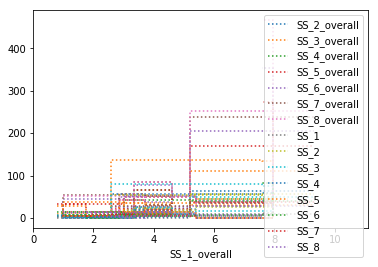

In [29]:
wrc.plot(x='SS_1_overall',drawstyle="steps-mid",linestyle=':')
plt.gca().invert_yaxis()